# GSDAE (Group Selective Deep AutoEncoder) for Danshen Analysis

基于方案文档的改进版本，包含：
1. 组稀疏正则化 (Group Lasso)
2. 半监督学习机制
3. 预测头 (Prediction Head)
4. 复合损失函数
5. 两层重要性分析

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import StandardScaler
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import optimizers, initializers
from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau

import keras_tuner as kt

## Data Loading and Preprocessing

In [2]:
# 读取数据
data = pd.read_csv('../data/丹参数据salvia_all_20240425 - 副本.csv')
print(f"原始数据形状: {data.shape}")

# 删除前三列
data = data.iloc[:, 3:]
print(f"删除前三列后数据形状: {data.shape}")

# 定义目标变量（丹参酮相关成分）
target_columns = [
    'CS', 'MT', 'TSIIA', 'TSI', 'DTSI', 'SumTS', 'PD', 'CFA', 'FA', 'SAD', 'SF', 'DSS',
    'SAC', 'SAE', 'MCF', 'RA', 'SAA', 'LA', 'SAY', 'TA', 'CTA', 'MA', 'FMA', 'SUA', 'SAB'
]

# 分离目标变量和特征
available_targets = [col for col in target_columns if col in data.columns]
target_data = data[available_targets] if available_targets else None

# 删除目标变量和其他不需要的列
drop_cols = available_targets + ['Soil_sampleN', 'etestN', 'testNp', 'etestpatch']
feature_data = data.drop(columns=[col for col in drop_cols if col in data.columns])

print(f"特征数据形状: {feature_data.shape}")
print(f"目标数据形状: {target_data.shape if target_data is not None else 'None'}")

原始数据形状: (991, 159)
删除前三列后数据形状: (991, 156)
特征数据形状: (991, 127)
目标数据形状: (991, 25)


In [3]:
# 数据预处理
thresh = len(feature_data) * 0.5
feature_data = feature_data.dropna(axis=1, thresh=thresh)

if target_data is not None:
    valid_indices = feature_data.dropna().index
    feature_data = feature_data.loc[valid_indices]
    target_data = target_data.loc[valid_indices]
    
    target_valid_indices = target_data.dropna().index
    feature_data = feature_data.loc[target_valid_indices]
    target_data = target_data.loc[target_valid_indices]
else:
    feature_data = feature_data.dropna()

# 独热编码
categorical_columns = ["Province", "City", "Microb", "Landscape", "SoilType", "soilclass", "CultivationType", "ClimateType", "按气候聚类划分的类型"]
categorical_columns = [col for col in categorical_columns if col in feature_data.columns]
feature_data = pd.get_dummies(feature_data, columns=categorical_columns, drop_first=True)

# 准备目标变量
if target_data is not None and 'SumTS' in target_data.columns:
    main_target = target_data[['SumTS']]
    print("使用SumTS作为主要目标变量")
elif target_data is not None:
    main_target = target_data.iloc[:, :1]
    print(f"使用{target_data.columns[0]}作为主要目标变量")
else:
    main_target = pd.DataFrame(np.random.randn(len(feature_data), 1), columns=['dummy_target'])
    print("创建虚拟目标变量")

print(f"最终特征数据形状: {feature_data.shape}")
print(f"目标变量形状: {main_target.shape}")

使用SumTS作为主要目标变量
最终特征数据形状: (496, 141)
目标变量形状: (496, 1)


In [4]:
# 数据分割和标准化
X_train, X_test, y_train, y_test = train_test_split(feature_data, main_target, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scal = scaler_X.fit_transform(X_train)
X_test_scal = scaler_X.transform(X_test)
y_train_scal = scaler_y.fit_transform(y_train)
y_test_scal = scaler_y.transform(y_test)

feature_names = list(feature_data.columns)
print(f"训练集: {X_train_scal.shape}, 测试集: {X_test_scal.shape}")
print(f"特征总数: {len(feature_names)}")

训练集: (396, 141), 测试集: (100, 141)
特征总数: 141


## Feature Grouping

In [5]:
def create_feature_groups(feature_names):
    """根据特征名称创建特征分组"""
    
    
    # 定义元素分组
    ee_elements = {'mn', 'cu', 'fe', 'zn', 'mg', 'k', 'ca', 'mo'} # 必需元素
    be_elements = {'v', 'na', 'co'} # 有益元素
    hm_elements = {'pb', 'cr', 'cd', 'as', 'sb', 'sn'} # 重金属元素
    re_elements = {'y', 'la', 'ce', 'pr', 'nd', 'sm', 'eu', 'gd', 'tb', 'dy', 'ho', 'er', 'yb', 'th'} # 稀土元素
    oe_elements = {'ga', 'rb', 'li', 'sr', 'ba', 'be', 'cs', 'ni', 'sc', 'ge', 'hf', 'nb', 'ti', 'zr'} # 其他元素
    
    
    groups = {
        '必需元素': [],
        '有益元素': [],
        '重金属元素': [],
        '稀土元素': [],
        '其他元素': [],
        '土壤元素': [],  
        '理化性质': [],
        '地理信息': [],
        '气候环境': [],
        '理化+元素':[]
    }
    
    for i, name in enumerate(feature_names):
        name_lower = name.lower()
        
        if any(climate in name_lower for climate in ['di','gdd0','gdd5','gp','mi','mtco','mtwa','tmax','tmin']):
            groups['气候环境'].append(i)
        elif name.endswith('_S'):
            groups['土壤元素'].append(i)
        elif any(nutrient in name_lower for nutrient in ['ph', 'ec', 'nh4_n', 'no3_n', 'n.n', 'tn', 'om', 'soiltypenum', 'an_x', 'ap_x', 'ak_x']):
            groups['理化性质'].append(i)
        elif any(geo in name_lower for geo in ['alt_extract', 'longitude', 'latitude']):
            groups['地理信息'].append(i)
        
        # if any(climate in name_lower for climate in ['di','gdd0','gdd5','gp','mi','mtco','mtwa','tmax','tmin']):
        #     groups['气候环境'].append(i)
        # if name.endswith('_S'):
        #     groups['理化+元素'].append(i)
        # elif any(nutrient in name_lower for nutrient in ['ph', 'ec', 'nh4_n', 'no3_n', 'n.n', 'tn', 'om', 'soiltypenum', 'an_x', 'ap_x', 'ak_x']):
        #     groups['理化+元素'].append(i)
        
        # # 检查是否为土壤元素
        # if name_lower.endswith('_s'):
        #     element = name_lower.split('_')[0]
        #     if element in ee_elements:
        #         groups['必需元素'].append(i)
        #     elif element in be_elements:
        #         groups['有益元素'].append(i)
        #     elif element in hm_elements:
        #         groups['重金属元素'].append(i)
        #     elif element in re_elements:
        #         groups['稀土元素'].append(i)
        #     elif element in oe_elements:
        #         groups['其他元素'].append(i)
        #     # 未分类的元素可以放在“其他”或单独处理，这里忽略


        
    
    # 移除空组
    groups = {k: v for k, v in groups.items() if len(v) > 0}
    return groups

# 创建特征分组
feature_groups = create_feature_groups(feature_names)
print(f"创建了 {len(feature_groups)} 个特征组:")
for group_name, indices in feature_groups.items():
    print(f"  - {group_name}: {len(indices)} 个特征")

创建了 4 个特征组:
  - 土壤元素: 45 个特征
  - 理化性质: 7 个特征
  - 地理信息: 3 个特征
  - 气候环境: 10 个特征


## GSDAE Model Definition

修改初始化范围
添加数值稳定性检查
        group_loss = tf.clip_by_value(group_loss, 0.0, 1e6)
        l1_loss = tf.clip_by_value(l1_loss, 0.0, 1e6)

In [6]:
class ZeroToOneClip(tf.keras.constraints.Constraint):
    """权重约束：限制在0-1之间"""
    def __call__(self, w):
        return tf.clip_by_value(w, 0, 1)

class GroupSelectiveLayer(keras.layers.Layer):
    """组选择层 - 支持组稀疏正则化的特征选择层"""
    def __init__(self, feature_groups, group_lasso_rate=0.01, l1_rate=0.001, **kwargs):
        super().__init__(**kwargs)
        self.feature_groups = feature_groups
        self.group_lasso_rate = group_lasso_rate
        self.l1_rate = l1_rate
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            "kernel", 
            shape=(int(input_shape[-1]),),
            
            # 修改初始化范围
            initializer=initializers.RandomUniform(minval=0.5, maxval=1.0),  # 修改初始化范围
            constraint=ZeroToOneClip(),
            trainable=True
        )
        
    def call(self, inputs):
        weighted_features = tf.multiply(inputs, self.kernel)
        
        # 添加组稀疏正则化损失
        group_loss = 0.0
        for group_indices in self.feature_groups.values():
            if len(group_indices) > 0:
                group_weights = tf.gather(self.kernel, group_indices)
                group_l2_norm = tf.norm(group_weights, ord=2)
                group_loss += group_l2_norm
        
        l1_loss = tf.reduce_sum(tf.abs(self.kernel))
        
        # 添加数值稳定性检查
        group_loss = tf.clip_by_value(group_loss, 0.0, 1e6)
        l1_loss = tf.clip_by_value(l1_loss, 0.0, 1e6)
        
        self.add_loss(self.group_lasso_rate * group_loss)
        self.add_loss(self.l1_rate * l1_loss)
        
        return weighted_features

In [7]:
def build_GSDAE(input_shape, target_dim, feature_groups, nbr_hidden_layers=3, hidden_layer_shape=12, encodings_nbr=6, activation="relu", group_lasso_rate=0.01, l1_rate=0.001):
    """构建GSDAE模型"""
    
    # 输入层
    feature_inputs = Input(shape=[input_shape], name='input')
    
    # 组选择层
    group_selective_layer = GroupSelectiveLayer(
        feature_groups=feature_groups,
        group_lasso_rate=group_lasso_rate,
        l1_rate=l1_rate,
        name='group_selective_layer'
    )
    selected_features = group_selective_layer(feature_inputs)
    
    # 编码器 - 原始特征路径
    encoder_full = feature_inputs
    for i in range(nbr_hidden_layers):
        encoder_full = Dense(hidden_layer_shape, activation=activation, name=f'encoder_hidden_layer_full_{i}')(encoder_full)
    
    # 编码器 - 选择特征路径  
    encoder_select = selected_features
    for i in range(nbr_hidden_layers):
        encoder_select = Dense(hidden_layer_shape, activation=activation, name=f'encoder_hidden_layer_select_{i}')(encoder_select)
    
    # 编码层
    encoding_full = Dense(encodings_nbr, activation=activation, name='encoding_layer_full')(encoder_full)
    encoding_select = Dense(encodings_nbr, activation=activation, name='encoding_layer_select')(encoder_select)
    
    # 预测头 - 用于半监督学习
    prediction_head = Dense(32, activation='relu', name='pred_hidden')(encoding_select)
    target_prediction = Dense(target_dim, activation='linear', name='target_prediction')(prediction_head)
    
    # 解码器 - 共享权重
    decoder_layers = []
    for i in range(nbr_hidden_layers):
        decoder_layer = Dense(hidden_layer_shape, activation=activation, name=f'decoder_hidden_layer_{i}')
        decoder_layers.append(decoder_layer)
    
    reconstruction_layer = Dense(input_shape, activation='linear', name='reconstruction_layer')
    
    # 应用解码器
    decoder_full = encoding_full
    decoder_select = encoding_select
    
    for decoder_layer in decoder_layers:
        decoder_full = decoder_layer(decoder_full)
        decoder_select = decoder_layer(decoder_select)
    
    # 重构输出
    reconstruction_full = reconstruction_layer(decoder_full)
    reconstruction_select = reconstruction_layer(decoder_select)
    
    # 构建模型
    gsdae_model = Model(inputs=feature_inputs, outputs=[reconstruction_select, target_prediction], name='GSDAE')
    full_autoencoder = Model(inputs=feature_inputs, outputs=reconstruction_full, name='FullAutoEncoder')
    feature_selector = Model(inputs=feature_inputs, outputs=selected_features, name='FeatureSelector')
    full_encoder = Model(inputs=feature_inputs, outputs=encoding_full, name='FullEncoder')
    select_encoder = Model(inputs=feature_inputs, outputs=encoding_select, name='SelectEncoder')
    
    return gsdae_model, full_autoencoder, feature_selector, full_encoder, select_encoder, group_selective_layer

## Build Model

lasso_rate = 1e-4  # 降低L1正则化率
group_lasso_rate = 1e-3  # 降低组稀疏正则化率

In [8]:
def build_model_for_tuning(hp):
    """用于KerasTuner的模型构建函数"""
    # 1. 定义超参数的搜索范围
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 5e-3])
    hp_group_lasso_rate = hp.Float('group_lasso_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    hp_l1_rate = hp.Float('l1_rate', min_value=1e-6, max_value=1e-3, sampling='log')
    hp_prediction_weight = hp.Choice('prediction_weight', values=[0.1, 0.2, 0.5, 1.0])

    # 2. 使用这些超参数构建模型
    # 注意：这里我们复用你已经写好的 build_GSDAE 函数
    gsdae_model, _, _, _, _, _ = build_GSDAE(
        input_shape=X_train_scal.shape[1],
        target_dim=y_train_scal.shape[1],
        feature_groups=feature_groups,
        nbr_hidden_layers=3,  # 固定结构参数
        hidden_layer_shape=12, # 固定结构参数
        encodings_nbr=6,       # 固定结构参数
        activation="relu",
        group_lasso_rate=hp_group_lasso_rate,
        l1_rate=hp_l1_rate
    )

    # 3. 编译模型
    optimizer = optimizers.Adam(learning_rate=hp_learning_rate, clipnorm=1.0)
    gsdae_model.compile(
        loss={'reconstruction_layer': 'mean_squared_error', 'target_prediction': 'mean_squared_error'},
        loss_weights={'reconstruction_layer': 1.0, 'target_prediction': hp_prediction_weight},
        optimizer=optimizer,
        metrics={'target_prediction': 'mae'} # 监控预测任务的mae
    )
    
    return gsdae_model

说是要注释掉

In [9]:
# # 参数设置
# lasso_rate = 1e-4  # 降低L1正则化率
# group_lasso_rate = 1e-3  # 降低组稀疏正则化率
# hidden_layer_shape = 12
# nbr_hidden_layers = 3
# encodings_nbr = 6
# activation = "relu"
# learning_rate = 1e-3
# nbr_batches = 20
# batch_size = int(np.floor(X_train_scal.shape[0]/nbr_batches))
# seed = 0

# # 设置随机种子
# random.seed(seed)
# rndm_seed = random.randint(1,10000)
# tf.random.set_seed(rndm_seed)

# print(f"批次大小: {batch_size}")
# print(f"随机种子: {rndm_seed}")
# print(f"L1正则化率: {lasso_rate}")
# print(f"组稀疏正则化率: {group_lasso_rate}")

In [10]:
# # 构建GSDAE模型
# GSDAE, FullAutoEncoder, FeatureSelector, FullEncoder, SelectEncoder, GroupSelectiveLayer = build_GSDAE(
#     input_shape=X_train_scal.shape[1],
#     target_dim=y_train_scal.shape[1],
#     feature_groups=feature_groups,
#     nbr_hidden_layers=nbr_hidden_layers,
#     hidden_layer_shape=hidden_layer_shape,
#     encodings_nbr=encodings_nbr,
#     activation=activation,
#     group_lasso_rate=group_lasso_rate,
#     l1_rate=lasso_rate
# )

# print("FullAutoEncoder Structure-------------------------------------")
# FullAutoEncoder.summary()
# print("GSDAE Structure-------------------------------------")
# GSDAE.summary()

## Pre-training: Full AutoEncoder

In [11]:
# # 预训练全特征自编码器
# FullAutoEncoder.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=learning_rate))
# history_pretrain = FullAutoEncoder.fit(
#     X_train_scal, X_train_scal, 
#     epochs=400, 
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(X_test_scal, X_test_scal),
#     verbose=1
# )

# # 评估预训练模型
# train_pred_full = FullAutoEncoder.predict(X_train_scal)
# test_pred_full = FullAutoEncoder.predict(X_test_scal)
# train_mse_full = mean_squared_error(X_train_scal, train_pred_full)
# test_mse_full = mean_squared_error(X_test_scal, test_pred_full)
# print(f"Full AutoEncoder - 训练MSE: {train_mse_full:.6f}")
# print(f"Full AutoEncoder - 测试MSE: {test_mse_full:.6f}")

## GSDAE Training

添加回调函数防止NaN
c

callbacks = [
    TerminateOnNaN(),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1)
]


optimizer = optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)  # 添加梯度裁剪


 loss_weights={'reconstruction_layer': 1.0, 'target_prediction': 0.1},  # 降低预测损失权重
    optimizer=optimizer,

In [12]:
# # GSDAE训练
# optimizer = optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)  # 添加梯度裁剪

# GSDAE.compile(
#     loss={'reconstruction_layer': 'mean_squared_error', 'target_prediction': 'mean_squared_error'},
#     loss_weights={'reconstruction_layer': 1.0, 'target_prediction': 0.1},  # 降低预测损失权重
#     optimizer=optimizer,
#     metrics=['mae']
# )

# # 准备训练数据
# train_outputs = {'reconstruction_layer': X_train_scal, 'target_prediction': y_train_scal}
# test_outputs = {'reconstruction_layer': X_test_scal, 'target_prediction': y_test_scal}

# callbacks = [
#     TerminateOnNaN(),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6, verbose=1)
# ]

# # 训练模型
# history_gsdae = GSDAE.fit(
#     X_train_scal, train_outputs,
#     epochs=200,  # 减少训练轮数
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(X_test_scal, test_outputs),
#     callbacks=callbacks,
#     verbose=1
# )

# print("GSDAE训练完成！")

加入新的单元格启动自动调参

In [13]:
# 1. 配置Tuner
# 定义一个简单、无中文的路径，并使用正斜杠
tuner_directory = 'D:/kerastuner_dir'

# 手动创建父目录，以增加稳定性
os.makedirs(tuner_directory, exist_ok=True)

tuner = kt.RandomSearch(
    build_model_for_tuning,
    objective=kt.Objective("val_target_prediction_mae", direction="min"), # 我们的目标是让验证集上预测任务的MAE最小
    max_trials=20,  # 总共尝试20种不同的超参数组合
    executions_per_trial=1, # 每组参数跑1次
    directory=tuner_directory, # 结果保存在这个文件夹
    project_name='gsdae_tuning',
    overwrite=True # <--- 添加这个参数，以便覆盖旧的/损坏的运行
)

# 2. 准备回调函数
# EarlyStopping可以在模型性能不再提升时提前停止，节省时间
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# 3. 开始搜索
nbr_batches = 20
batch_size = int(np.floor(X_train_scal.shape[0]/nbr_batches))
print(f"使用的批次大小: {batch_size}")

print("开始超参数搜索...")
tuner.search(
    X_train_scal, 
    {'reconstruction_layer': X_train_scal, 'target_prediction': y_train_scal},
    epochs=150, # 每次试验最多跑100轮
    batch_size=batch_size, # 使用你之前定义的batch_size
    validation_data=(X_test_scal, {'reconstruction_layer': X_test_scal, 'target_prediction': y_test_scal}),
    callbacks=[stop_early, TerminateOnNaN()] # 加入回调
)

# 4. 输出最佳结果
print("\n搜索完成！")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("最佳超参数组合:")
print(f" - learning_rate: {best_hps.get('learning_rate')}")
print(f" - group_lasso_rate: {best_hps.get('group_lasso_rate')}")
print(f" - l1_rate: {best_hps.get('l1_rate')}")
print(f" - prediction_weight: {best_hps.get('prediction_weight')}")

# # 5. 获取最佳模型并进行评估
# best_model = tuner.get_best_models(num_models=1)[0]
# # 你可以用这个 best_model 替换掉原来的 GSDAE 模型，然后运行后续的评估和分析代码
# GSDAE = best_model

# 5. 获取最佳模型并用最佳参数重新训练以获取history
print("\n使用最佳超参数重新训练最终模型...")
GSDAE = tuner.hypermodel.build(best_hps) # 使用最佳参数构建一个新模型

# 准备训练数据
train_outputs = {'reconstruction_layer': X_train_scal, 'target_prediction': y_train_scal}
test_outputs = {'reconstruction_layer': X_test_scal, 'target_prediction': y_test_scal}

# 重新训练并保存history
history_gsdae = GSDAE.fit(
    X_train_scal, train_outputs,
    epochs=150,  # 可以使用一个合适的轮数进行最终训练
    batch_size=batch_size,
    validation_data=(X_test_scal, test_outputs),
    callbacks=[stop_early, TerminateOnNaN()],
    verbose=1
)

print("最终模型训练完成！")

Trial 20 Complete [00h 00m 04s]
val_target_prediction_mae: 0.45821067690849304

Best val_target_prediction_mae So Far: 0.39884185791015625
Total elapsed time: 00h 02m 17s

搜索完成！
最佳超参数组合:
 - learning_rate: 0.005
 - group_lasso_rate: 0.0001492073979042345
 - l1_rate: 2.7255731067274567e-05
 - prediction_weight: 0.1

使用最佳超参数重新训练最终模型...
Epoch 1/150
21/21 [==============================] - 1s 8ms/step - loss: 1.0648 - reconstruction_layer_loss: 0.9700 - target_prediction_loss: 0.9038 - target_prediction_mae: 0.7461 - val_loss: 1.2200 - val_reconstruction_layer_loss: 1.1414 - val_target_prediction_loss: 0.7418 - val_target_prediction_mae: 0.6511
Epoch 2/150
21/21 [==============================] - 0s 2ms/step - loss: 0.9210 - reconstruction_layer_loss: 0.8529 - target_prediction_loss: 0.6378 - target_prediction_mae: 0.6072 - val_loss: 1.1205 - val_reconstruction_layer_loss: 1.0519 - val_target_prediction_loss: 0.6418 - val_target_prediction_mae: 0.5904
Epoch 3/150
21/21 [====================

In [14]:
# 数据质量检查
print("=== 数据质量检查 ===")
print(f"X_train_scal - 是否包含NaN: {np.isnan(X_train_scal).any()}")
print(f"X_train_scal - 是否包含inf: {np.isinf(X_train_scal).any()}")
print(f"X_train_scal - 最大值: {X_train_scal.max():.6f}")
print(f"X_train_scal - 最小值: {X_train_scal.min():.6f}")
print(f"X_train_scal - 标准差: {X_train_scal.std():.6f}")

print(f"y_train_scal - 是否包含NaN: {np.isnan(y_train_scal).any()}")
print(f"y_train_scal - 是否包含inf: {np.isinf(y_train_scal).any()}")
print(f"y_train_scal - 最大值: {y_train_scal.max():.6f}")
print(f"y_train_scal - 最小值: {y_train_scal.min():.6f}")

# 检查是否有异常大的值
extreme_threshold = 10
extreme_features = np.abs(X_train_scal) > extreme_threshold
if extreme_features.any():
    print(f"警告: 发现 {extreme_features.sum()} 个异常大的特征值 (>10)")

print("=" * 30)

=== 数据质量检查 ===
X_train_scal - 是否包含NaN: False
X_train_scal - 是否包含inf: False
X_train_scal - 最大值: 18.497204
X_train_scal - 最小值: -3.374657
X_train_scal - 标准差: 1.000000
y_train_scal - 是否包含NaN: False
y_train_scal - 是否包含inf: False
y_train_scal - 最大值: 3.066656
y_train_scal - 最小值: -1.250043
警告: 发现 5 个异常大的特征值 (>10)


In [15]:
# # 改进的训练策略 - 解决长期训练NaN问题

# # 1. 进一步降低正则化参数
# improved_group_lasso_rate = 1e-4  # 从1e-3降低到1e-4
# improved_l1_rate = 1e-5          # 从1e-4降低到1e-5

# print(f"改进的正则化参数:")
# print(f"组稀疏正则化率: {improved_group_lasso_rate}")
# print(f"L1正则化率: {improved_l1_rate}")

# # 2. 创建改进的组选择层
# class ImprovedGroupSelectiveLayer(keras.layers.Layer):
#     """改进的组选择层 - 更稳定的训练"""
#     def __init__(self, feature_groups, group_lasso_rate=0.01, l1_rate=0.001, **kwargs):
#         super().__init__(**kwargs)
#         self.feature_groups = feature_groups
#         self.group_lasso_rate = group_lasso_rate
#         self.l1_rate = l1_rate
        
#     def build(self, input_shape):
#         # 使用更保守的初始化
#         self.kernel = self.add_weight(
#             "kernel", 
#             shape=(int(input_shape[-1]),),
#             initializer=initializers.RandomUniform(minval=0.8, maxval=1.0),  # 更保守的范围
#             constraint=ZeroToOneClip(),
#             trainable=True
#         )
        
#     def call(self, inputs):
#         # 添加小的epsilon避免数值问题
#         epsilon = 1e-7
#         weighted_features = tf.multiply(inputs, self.kernel + epsilon)
        
#         # 计算正则化损失时添加更多稳定性检查
#         group_loss = 0.0
#         for group_indices in self.feature_groups.values():
#             if len(group_indices) > 0:
#                 group_weights = tf.gather(self.kernel, group_indices)
#                 # 添加epsilon避免除零
#                 group_l2_norm = tf.norm(group_weights + epsilon, ord=2)
#                 group_loss += group_l2_norm
        
#         l1_loss = tf.reduce_sum(tf.abs(self.kernel + epsilon))
        
#         # 更激进的数值裁剪
#         group_loss = tf.clip_by_value(group_loss, 0.0, 10.0)  # 从1e6降低到10
#         l1_loss = tf.clip_by_value(l1_loss, 0.0, 10.0)
        
#         # 添加损失时检查是否为NaN
#         group_loss = tf.where(tf.math.is_nan(group_loss), 0.0, group_loss)
#         l1_loss = tf.where(tf.math.is_nan(l1_loss), 0.0, l1_loss)
        
#         self.add_loss(self.group_lasso_rate * group_loss)
#         self.add_loss(self.l1_rate * l1_loss)
        
#         return weighted_features

# # 3. 改进的模型构建函数
# def build_improved_GSDAE(input_shape, target_dim, feature_groups, 
#                         nbr_hidden_layers=3, hidden_layer_shape=12, 
#                         encodings_nbr=6, activation="relu", 
#                         group_lasso_rate=0.01, l1_rate=0.001):
#     """构建改进的GSDAE模型"""
    
#     # 输入层
#     feature_inputs = Input(shape=[input_shape], name='input')
    
#     # 改进的组选择层
#     group_selective_layer = ImprovedGroupSelectiveLayer(
#         feature_groups=feature_groups,
#         group_lasso_rate=group_lasso_rate,
#         l1_rate=l1_rate,
#         name='improved_group_selective_layer'
#     )
#     selected_features = group_selective_layer(feature_inputs)
    
#     # 编码器 - 使用LeakyReLU提高稳定性
#     encoder_full = feature_inputs
#     for i in range(nbr_hidden_layers):
#         encoder_full = Dense(hidden_layer_shape, activation='linear', name=f'encoder_hidden_layer_full_{i}')(encoder_full)
#         encoder_full = keras.layers.LeakyReLU(alpha=0.01)(encoder_full)
#         encoder_full = keras.layers.BatchNormalization()(encoder_full)  # 添加BatchNorm
    
#     encoder_select = selected_features
#     for i in range(nbr_hidden_layers):
#         encoder_select = Dense(hidden_layer_shape, activation='linear', name=f'encoder_hidden_layer_select_{i}')(encoder_select)
#         encoder_select = keras.layers.LeakyReLU(alpha=0.01)(encoder_select)
#         encoder_select = keras.layers.BatchNormalization()(encoder_select)
    
#     # 编码层
#     encoding_full = Dense(encodings_nbr, activation='linear', name='encoding_layer_full')(encoder_full)
#     encoding_full = keras.layers.LeakyReLU(alpha=0.01)(encoding_full)
    
#     encoding_select = Dense(encodings_nbr, activation='linear', name='encoding_layer_select')(encoder_select)
#     encoding_select = keras.layers.LeakyReLU(alpha=0.01)(encoding_select)
    
#     # 预测头
#     prediction_head = Dense(32, activation='linear', name='pred_hidden')(encoding_select)
#     prediction_head = keras.layers.LeakyReLU(alpha=0.01)(prediction_head)
#     prediction_head = keras.layers.BatchNormalization()(prediction_head)
#     target_prediction = Dense(target_dim, activation='linear', name='target_prediction')(prediction_head)
    
#     # 解码器
#     decoder_layers = []
#     for i in range(nbr_hidden_layers):
#         decoder_layer = Dense(hidden_layer_shape, activation='linear', name=f'decoder_hidden_layer_{i}')
#         decoder_layers.append(decoder_layer)
    
#     reconstruction_layer = Dense(input_shape, activation='linear', name='reconstruction_layer')
    
#     # 应用解码器
#     decoder_full = encoding_full
#     decoder_select = encoding_select
    
#     for i, decoder_layer in enumerate(decoder_layers):
#         decoder_full = decoder_layer(decoder_full)
#         decoder_full = keras.layers.LeakyReLU(alpha=0.01)(decoder_full)
#         decoder_full = keras.layers.BatchNormalization()(decoder_full)
        
#         decoder_select = decoder_layer(decoder_select)
#         decoder_select = keras.layers.LeakyReLU(alpha=0.01)(decoder_select)
#         decoder_select = keras.layers.BatchNormalization()(decoder_select)
    
#     # 重构输出
#     reconstruction_full = reconstruction_layer(decoder_full)
#     reconstruction_select = reconstruction_layer(decoder_select)
    
#     # 构建模型
#     gsdae_model = Model(inputs=feature_inputs, outputs=[reconstruction_select, target_prediction], name='ImprovedGSDAE')
#     full_autoencoder = Model(inputs=feature_inputs, outputs=reconstruction_full, name='ImprovedFullAutoEncoder')
#     feature_selector = Model(inputs=feature_inputs, outputs=selected_features, name='ImprovedFeatureSelector')
    
#     return gsdae_model, full_autoencoder, feature_selector, group_selective_layer

In [16]:
# # 4. 构建改进的模型
# print("构建改进的GSDAE模型...")
# ImprovedGSDAE, ImprovedFullAutoEncoder, ImprovedFeatureSelector, ImprovedGroupSelectiveLayer = build_improved_GSDAE(
#     input_shape=X_train_scal.shape[1],
#     target_dim=y_train_scal.shape[1],
#     feature_groups=feature_groups,
#     nbr_hidden_layers=nbr_hidden_layers,
#     hidden_layer_shape=hidden_layer_shape,
#     encodings_nbr=encodings_nbr,
#     group_lasso_rate=improved_group_lasso_rate,
#     l1_rate=improved_l1_rate
# )

# # 5. 改进的训练配置
# print("配置改进的训练参数...")

# # 使用更激进的学习率衰减
# initial_learning_rate = 1e-3
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100,
#     decay_rate=0.9,
#     staircase=True
# )

# # 改进的优化器配置
# improved_optimizer = optimizers.Adam(
#     learning_rate=lr_schedule,
#     clipnorm=0.5,  # 更激进的梯度裁剪
#     clipvalue=0.5   # 添加值裁剪
# )

# # 编译改进的模型
# ImprovedGSDAE.compile(
#     loss={'reconstruction_layer': 'mean_squared_error', 'target_prediction': 'mean_squared_error'},
#     loss_weights={'reconstruction_layer': 0.8, 'target_prediction': 0.2},  # 调整权重比例
#     optimizer=improved_optimizer,
#     metrics=['mae']
# )

# # 6. 改进的回调函数
# improved_callbacks = [
#     TerminateOnNaN(),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
#     keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
#     # 添加自定义回调监控训练过程
#     keras.callbacks.LambdaCallback(
#         on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch}: loss={logs.get('loss', 0):.6f}, val_loss={logs.get('val_loss', 0):.6f}")
#         if epoch % 10 == 0 else None
#     )
# ]

# print("改进的模型配置完成！")
# print("主要改进:")
# print("1. 更低的正则化参数")
# print("2. 更保守的权重初始化(0.8-1.0)")
# print("3. LeakyReLU + BatchNormalization")
# print("4. 指数学习率衰减")
# print("5. 更激进的梯度裁剪")
# print("6. 调整的损失权重")
# print("7. 更多数值稳定性检查")

In [17]:
# # 7. 稳定的长期训练测试
# print("开始改进的GSDAE训练...")
# print("=" * 50)

# # 准备训练数据
# train_outputs = {'reconstruction_layer': X_train_scal, 'target_prediction': y_train_scal}
# test_outputs = {'reconstruction_layer': X_test_scal, 'target_prediction': y_test_scal}

# try:
#     # 训练改进的模型 - 现在可以使用更多轮数
#     history_improved = ImprovedGSDAE.fit(
#         X_train_scal, train_outputs,
#         epochs=100,  # 现在可以安全地使用更多轮数
#         batch_size=batch_size,
#         shuffle=True,
#         validation_data=(X_test_scal, test_outputs),
#         callbacks=improved_callbacks,
#         verbose=0  # 减少输出，使用回调函数监控
#     )
    
#     print("✅ 改进的GSDAE训练成功完成！")
#     print(f"训练轮数: {len(history_improved.history['loss'])}")
#     print(f"最终训练损失: {history_improved.history['loss'][-1]:.6f}")
#     print(f"最终验证损失: {history_improved.history['val_loss'][-1]:.6f}")
    
#     # 检查是否存在NaN
#     final_loss = history_improved.history['loss'][-1]
#     final_val_loss = history_improved.history['val_loss'][-1]
    
#     if np.isnan(final_loss) or np.isnan(final_val_loss):
#         print("❌ 仍然出现NaN，需要进一步调整参数")
#     else:
#         print("✅ 训练过程稳定，无NaN问题")
        
# except Exception as e:
#     print(f"❌ 训练过程中出现错误: {e}")

# print("=" * 50)

In [18]:
# NaN问题诊断工具
def diagnose_nan_issue(model, X_sample, y_sample):
    """诊断模型中的NaN问题"""
    print("=== NaN问题诊断 ===")
    
    # 1. 检查模型权重
    print("1. 检查模型权重:")
    for layer in model.layers:
        if hasattr(layer, 'kernel') and layer.kernel is not None:
            weights = layer.kernel.numpy()
            if np.isnan(weights).any():
                print(f"   ❌ {layer.name}: 发现NaN权重")
            elif np.isinf(weights).any():
                print(f"   ⚠️  {layer.name}: 发现无穷大权重")
            else:
                weight_max = np.max(np.abs(weights))
                print(f"   ✅ {layer.name}: 权重正常 (最大绝对值: {weight_max:.6f})")
    
    # 2. 检查前向传播
    print("\n2. 检查前向传播:")
    try:
        outputs = model.predict(X_sample[:5], verbose=0)
        if isinstance(outputs, list):
            for i, output in enumerate(outputs):
                if np.isnan(output).any():
                    print(f"   ❌ 输出{i}: 包含NaN")
                elif np.isinf(output).any():
                    print(f"   ⚠️  输出{i}: 包含无穷大")
                else:
                    print(f"   ✅ 输出{i}: 正常")
        else:
            if np.isnan(outputs).any():
                print("   ❌ 输出: 包含NaN")
            elif np.isinf(outputs).any():
                print("   ⚠️  输出: 包含无穷大")
            else:
                print("   ✅ 输出: 正常")
    except Exception as e:
        print(f"   ❌ 前向传播失败: {e}")
    
    # 3. 检查损失计算
    print("\n3. 检查损失计算:")
    try:
        loss = model.evaluate(X_sample[:5], {'reconstruction_layer': X_sample[:5], 
                                           'target_prediction': y_sample[:5]}, verbose=0)
        if np.isnan(loss[0]):
            print(f"   ❌ 总损失: NaN")
        else:
            print(f"   ✅ 总损失: {loss[0]:.6f}")
    except Exception as e:
        print(f"   ❌ 损失计算失败: {e}")
    
    print("=" * 30)

# 运行原始模型的诊断（如果已训练）
if 'GSDAE' in locals() and 'history_gsdae' in locals():
    print("诊断原始GSDAE模型:")
    diagnose_nan_issue(GSDAE, X_train_scal, y_train_scal)

# 快速训练测试 - 逐步增加轮数观察何时出现NaN
def gradual_training_test(model, X_train, y_train, X_val, y_val, max_epochs=50):
    """逐步增加训练轮数，观察NaN出现的时机"""
    print("=== 逐步训练测试 ===")
    
    train_outputs = {'reconstruction_layer': X_train, 'target_prediction': y_train}
    val_outputs = {'reconstruction_layer': X_val, 'target_prediction': y_val}
    
    step_sizes = [5, 10, 20, 30, 50]
    
    for epochs in step_sizes:
        if epochs > max_epochs:
            break
            
        print(f"\n测试 {epochs} 轮训练:")
        try:
            # 重新编译模型确保干净状态
            model.compile(
                loss={'reconstruction_layer': 'mean_squared_error', 'target_prediction': 'mean_squared_error'},
                loss_weights={'reconstruction_layer': 1.0, 'target_prediction': 0.1},
                optimizer=optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
                metrics=['mae']
            )
            
            history = model.fit(
                X_train, train_outputs,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, val_outputs),
                callbacks=[TerminateOnNaN()],
                verbose=0
            )
            
            final_loss = history.history['loss'][-1]
            final_val_loss = history.history['val_loss'][-1]
            
            if np.isnan(final_loss) or np.isnan(final_val_loss):
                print(f"   ❌ {epochs}轮后出现NaN - 临界点找到！")
                break
            else:
                print(f"   ✅ {epochs}轮训练正常 (loss: {final_loss:.6f})")
                
        except Exception as e:
            print(f"   ❌ {epochs}轮训练失败: {e}")
            break
    
    print("=" * 30)

print("可以使用以下函数进行诊断:")
print("1. diagnose_nan_issue(model, X_sample, y_sample) - 诊断当前模型状态")
print("2. gradual_training_test(model, X_train, y_train, X_val, y_val) - 找到NaN出现的临界点")

诊断原始GSDAE模型:
=== NaN问题诊断 ===
1. 检查模型权重:
   ✅ group_selective_layer: 权重正常 (最大绝对值: 0.993036)
   ✅ encoder_hidden_layer_select_0: 权重正常 (最大绝对值: 0.829555)
   ✅ encoder_hidden_layer_select_1: 权重正常 (最大绝对值: 1.202824)
   ✅ encoder_hidden_layer_select_2: 权重正常 (最大绝对值: 0.793363)
   ✅ encoding_layer_select: 权重正常 (最大绝对值: 0.871314)
   ✅ decoder_hidden_layer_0: 权重正常 (最大绝对值: 1.322005)
   ✅ decoder_hidden_layer_1: 权重正常 (最大绝对值: 0.931971)
   ✅ decoder_hidden_layer_2: 权重正常 (最大绝对值: 1.568721)
   ✅ pred_hidden: 权重正常 (最大绝对值: 1.524363)
   ✅ reconstruction_layer: 权重正常 (最大绝对值: 1.145010)
   ✅ target_prediction: 权重正常 (最大绝对值: 0.628376)

2. 检查前向传播:
   ✅ 输出0: 正常
   ✅ 输出1: 正常

3. 检查损失计算:
   ✅ 总损失: 0.203914
可以使用以下函数进行诊断:
1. diagnose_nan_issue(model, X_sample, y_sample) - 诊断当前模型状态
2. gradual_training_test(model, X_train, y_train, X_val, y_val) - 找到NaN出现的临界点


## Model Evaluation and Feature Importance Analysis

In [19]:
# 评估GSDAE模型
train_pred_gsdae = GSDAE.predict(X_train_scal)
test_pred_gsdae = GSDAE.predict(X_test_scal)

train_recon_gsdae, train_target_pred = train_pred_gsdae
test_recon_gsdae, test_target_pred = test_pred_gsdae

# 计算误差
train_mse_recon = mean_squared_error(X_train_scal, train_recon_gsdae)
test_mse_recon = mean_squared_error(X_test_scal, test_recon_gsdae)
train_mse_pred = mean_squared_error(y_train_scal, train_target_pred)
test_mse_pred = mean_squared_error(y_test_scal, test_target_pred)

# 新增：MAE（标准化尺度）
train_mae_recon = mean_absolute_error(X_train_scal, train_recon_gsdae)
test_mae_recon  = mean_absolute_error(X_test_scal, test_recon_gsdae)
train_mae_pred  = mean_absolute_error(y_train_scal, train_target_pred)
test_mae_pred   = mean_absolute_error(y_test_scal, test_target_pred)




# 反标准化计算R²
train_target_pred_orig = scaler_y.inverse_transform(train_target_pred)
test_target_pred_orig = scaler_y.inverse_transform(test_target_pred)
y_train_orig = scaler_y.inverse_transform(y_train_scal)
y_test_orig = scaler_y.inverse_transform(y_test_scal)

train_r2 = r2_score(y_train_orig, train_target_pred_orig)
test_r2 = r2_score(y_test_orig, test_target_pred_orig)

# 新增：目标MAE（原单位，便于解读）
train_mae_pred_orig = mean_absolute_error(y_train_orig, train_target_pred_orig)
test_mae_pred_orig  = mean_absolute_error(y_test_orig,  test_target_pred_orig)

print("=" * 50)
print("GSDAE模型评估结果:")
print("=" * 50)
print(f"重构任务 - 训练MSE: {train_mse_recon:.6f}")
print(f"重构任务 - 测试MSE: {test_mse_recon:.6f}")
print(f"重构任务 - 训练MAE: {train_mae_recon:.6f}")
print(f"重构任务 - 测试MAE: {test_mae_recon:.6f}")
print(f"预测任务 - 训练MSE: {train_mse_pred:.6f}")
print(f"预测任务 - 测试MSE: {test_mse_pred:.6f}")
print(f"预测任务 - 训练MAE(标准化): {train_mae_pred:.6f}")
print(f"预测任务 - 测试MAE(标准化): {test_mae_pred:.6f}")
print(f"目标预测 - 训练MAE(原单位): {train_mae_pred_orig:.6f}")
print(f"目标预测 - 测试MAE(原单位): {test_mae_pred_orig:.6f}")
print(f"目标预测 - 训练R²: {train_r2:.4f}")
print(f"目标预测 - 测试R²: {test_r2:.4f}")
print("=" * 50)

4/4 [==============================] - 0s 0s/step
GSDAE模型评估结果:
重构任务 - 训练MSE: 0.319230
重构任务 - 测试MSE: 0.460699
重构任务 - 训练MAE: 0.348206
重构任务 - 测试MAE: 0.390778
预测任务 - 训练MSE: 0.168891
预测任务 - 测试MSE: 0.490682
预测任务 - 训练MAE(标准化): 0.298316
预测任务 - 测试MAE(标准化): 0.510757
目标预测 - 训练MAE(原单位): 1.312036
目标预测 - 测试MAE(原单位): 2.246380
目标预测 - 训练R²: 0.8311
目标预测 - 测试R²: 0.3868


In [20]:
# # 特征重要性分析
# def analyze_feature_importance(group_selective_layer, feature_groups, feature_names):
#     """两层重要性分析"""
#     weights = group_selective_layer.kernel.numpy()
    
#     # 组重要性评估
#     group_importance = {}
#     for group_name, indices in feature_groups.items():
#         if len(indices) > 0:
#             group_weights = weights[indices]
#             group_l2_norm = np.linalg.norm(group_weights, ord=2)
#             group_importance[group_name] = group_l2_norm
    
#     sorted_groups = sorted(group_importance.items(), key=lambda x: x[1], reverse=True)
    
#     # 组内关键特征识别
#     feature_importance = {}
#     for group_name, indices in feature_groups.items():
#         if len(indices) > 0:
#             group_weights = weights[indices]
#             group_features = [feature_names[i] for i in indices]
#             feature_weight_pairs = list(zip(group_features, group_weights))
#             sorted_features = sorted(feature_weight_pairs, key=lambda x: x[1], reverse=True)
#             feature_importance[group_name] = sorted_features
    
#     return sorted_groups, feature_importance, weights

# # 执行重要性分析
# sorted_groups, feature_importance, weights = analyze_feature_importance(
#     GroupSelectiveLayer, feature_groups, feature_names
# )

# print("特征组重要性排名:")
# for i, (group_name, importance) in enumerate(sorted_groups):
#     print(f"{i+1:2d}. {group_name:12s}: {importance:.4f}")

# print("\n各组内关键特征 (前3个):")
# for group_name, features in feature_importance.items():
#     print(f"\n{group_name}:")
#     for i, (feat_name, weight) in enumerate(features[:3]):
#         print(f"  {i+1}. {feat_name}: {weight:.4f}")

In [21]:
# ...existing code...
def analyze_feature_importance(group_selective_layer, feature_groups, feature_names, 
                               metric='l2', normalize=True, top_k=None):
    """两层重要性分析；metric: 'l2'|'l1'|'max'|'mean'；normalize=True时做组大小归一化"""
    weights = group_selective_layer.kernel.numpy()

    # 组重要性评估
    group_importance = {}
    for group_name, indices in feature_groups.items():
        if len(indices) == 0:
            continue
        gw = weights[indices]

        # 可选：仅取组内Top-K权重再评估
        if top_k is not None and top_k < len(gw):
            gw = np.sort(gw)[-top_k:]

        if metric == 'l2':
            score = np.linalg.norm(gw, ord=2)
            if normalize:
                score = score / np.sqrt(len(gw))   # RMS：消除组大小影响
        elif metric == 'l1':
            score = np.sum(np.abs(gw))
            if normalize:
                score = score / len(gw)           # 平均绝对权重
        elif metric == 'max':
            score = float(np.max(gw))
        else:  # 'mean'
            score = float(np.mean(gw))
        group_importance[group_name] = float(score)

    sorted_groups = sorted(group_importance.items(), key=lambda x: x[1], reverse=True)

    # 组内关键特征识别（保持原逻辑）
    feature_importance = {}
    for group_name, indices in feature_groups.items():
        if len(indices) == 0:
            continue
        gw = weights[indices]
        gf = [feature_names[i] for i in indices]
        feature_importance[group_name] = sorted(zip(gf, gw), key=lambda x: x[1], reverse=True)

    return sorted_groups, feature_importance, weights

# 调用示例：用RMS做组评分
# 从训练好的GSDAE模型中按名称获取组选择层的实例
group_selective_layer_instance = GSDAE.get_layer('group_selective_layer')

sorted_groups, feature_importance, weights = analyze_feature_importance(
    group_selective_layer_instance, feature_groups, feature_names,
    metric='l2', normalize=True  # 或 metric='l1', normalize=True 为L1平均
)


print("特征组重要性排名:")
for i, (group_name, importance) in enumerate(sorted_groups):
    print(f"{i+1:2d}. {group_name:12s}: {importance:.4f}")

print("\n各组内关键特征 (前3个):")
for group_name, features in feature_importance.items():
    print(f"\n{group_name}:")
    for i, (feat_name, weight) in enumerate(features[:3]):
        print(f"  {i+1}. {feat_name}: {weight:.4f}")

特征组重要性排名:
 1. 土壤元素        : 0.5554
 2. 气候环境        : 0.4832
 3. 理化性质        : 0.4490
 4. 地理信息        : 0.2427

各组内关键特征 (前3个):

土壤元素:
  1. Ti_S: 0.9570
  2. Sc_S: 0.9216
  3. Sr_S: 0.9039

理化性质:
  1. EC: 0.6373
  2. pH: 0.6292
  3. OM: 0.4436

地理信息:
  1. Longitude: 0.3494
  2. Latitude: 0.2180
  3. ALT_extract: 0.0841

气候环境:
  1. GDD0: 0.7694
  2. MTCO: 0.6051
  3. MTWA: 0.5741


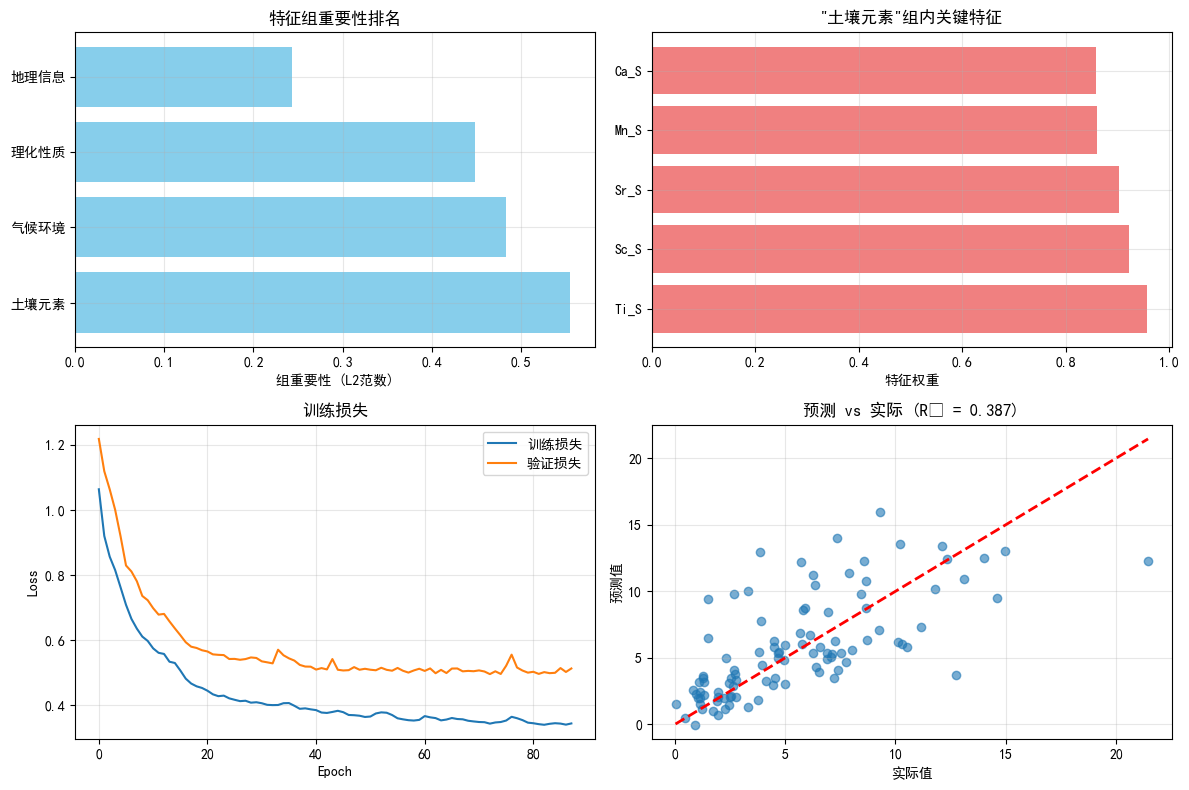

In [22]:
# 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 组重要性
top_n_groups = min(8, len(sorted_groups))
groups = [item[0] for item in sorted_groups[:top_n_groups]]
importance = [item[1] for item in sorted_groups[:top_n_groups]]

axes[0, 0].barh(groups, importance, color='skyblue')
axes[0, 0].set_xlabel('组重要性 (L2范数)')
axes[0, 0].set_title('特征组重要性排名')
axes[0, 0].grid(True, alpha=0.3)

# 最重要组的关键特征
if sorted_groups:
    top_group = sorted_groups[0][0]
    top_features = feature_importance[top_group][:5]
    
    feature_names_short = [item[0][:15] + '...' if len(item[0]) > 15 else item[0] for item in top_features]
    feature_weights = [item[1] for item in top_features]
    
    axes[0, 1].barh(feature_names_short, feature_weights, color='lightcoral')
    axes[0, 1].set_xlabel('特征权重')
    axes[0, 1].set_title(f'"{top_group}"组内关键特征')
    axes[0, 1].grid(True, alpha=0.3)

# 训练损失
axes[1, 0].plot(history_gsdae.history['loss'], label='训练损失')
axes[1, 0].plot(history_gsdae.history['val_loss'], label='验证损失')
axes[1, 0].set_title('训练损失')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 预测准确性
axes[1, 1].scatter(y_test_orig, test_target_pred_orig, alpha=0.6)
axes[1, 1].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('实际值')
axes[1, 1].set_ylabel('预测值')
axes[1, 1].set_title(f'预测 vs 实际 (R² = {test_r2:.3f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary\n
\n
### GSDAE模型总结\n
\n
本notebook实现了基于方案文档的GSDAE模型，主要改进包括：\n
\n
1. **组稀疏正则化**: 针对生态因子的天然分组结构\n
2. **半监督学习**: 引入丹参酮含量作为监督信号\n
3. **预测头**: 专门的预测分支用于药效成分含量预测\n
4. **复合损失函数**: 重构误差 + 预测误差 + 组稀疏正则化\n
5. **两层重要性分析**: 组重要性评估 + 组内关键特征识别\n
\n
### 模型优势\n
\n
- **生物学意义**: 特征分组符合生态因子的天然结构\n
- **目标导向**: 半监督学习机制与药效预测任务对齐\n
- **可解释性**: 提供宏观到微观的多层次分析结果\n
- **实用性**: 同时完成特征选择、降维和预测任务

#### 绘制图


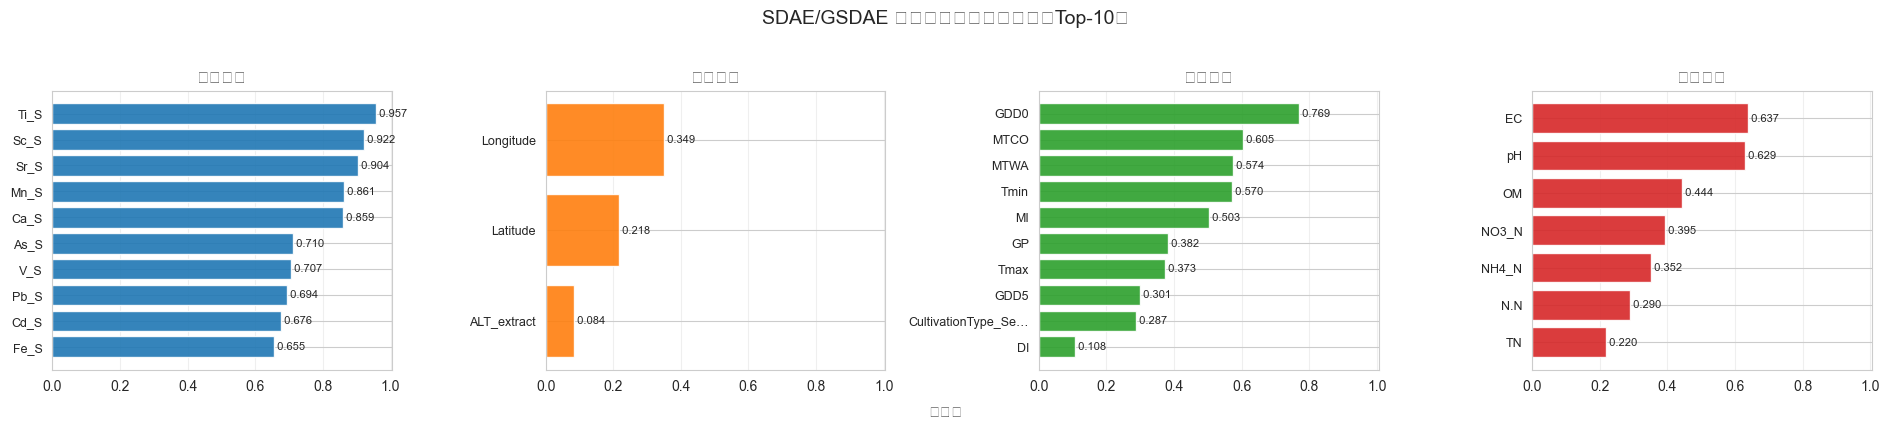

In [23]:
# 可视化：各特征组 Top-10 特征权重分布面板（类似图1）
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

sns.set_style("whitegrid")

def _get_layer_kernel(layer):
    if hasattr(layer, "kernel") and layer.kernel is not None:
        w = layer.kernel.numpy()
        return np.asarray(w, dtype=float)
    raise ValueError("layer 不含 kernel 权重，请确认传入的是 GroupSelectiveLayer/ImprovedGroupSelectiveLayer 的实例。")

def compute_group_feature_weights(layer, feature_groups, feature_names):
    """返回 {组名: [(特征名, 权重), ...]}"""
    weights = _get_layer_kernel(layer)
    result = {}
    for g, idx in feature_groups.items():
        if len(idx) == 0:
            continue
        pairs = [(feature_names[i], float(weights[i])) for i in idx]
        # 只保留非负权重（该层已约束到[0,1]，此处为稳健性）
        pairs = [(n, max(0.0, w)) for n, w in pairs]
        result[g] = pairs
    return result

def plot_group_weight_panels(group_feature_weights, top_k=10, group_order=None, ncols=4):
    """绘制各组Top-K特征权重面板"""
    # 组显示顺序
    keys = list(group_feature_weights.keys())
    if group_order:
        ordered = [g for g in group_order if g in group_feature_weights] + [g for g in keys if g not in group_order]
    else:
        ordered = keys

    ordered_map = OrderedDict((g, group_feature_weights[g]) for g in ordered)
    ng = len(ordered_map)
    ncols = min(ncols, max(1, ng))
    nrows = int(np.ceil(ng / ncols))

    # 统一x轴上限，便于对比
    global_max = 0.0
    for feats in ordered_map.values():
        if feats:
            global_max = max(global_max, max(w for _, w in feats))
    global_max = max(global_max, 1e-6) * 1.05

    # 颜色：每组一个主色
    palette = sns.color_palette("tab10", n_colors=max(10, ng))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.6*ncols+0.6, 3.2*nrows+1), squeeze=False, sharex=True)
    ax_list = axes.flatten()

    # 先关掉所有坐标轴，避免空格子显示框线
    for ax in ax_list:
        ax.axis("off")

    for i, (g, feats) in enumerate(ordered_map.items()):
        ax = ax_list[i]
        ax.axis("on")
        feats_sorted = sorted(feats, key=lambda x: x[1], reverse=True)[:top_k]
        # 反向画水平条，便于从上到下显示从小到大
        names = [n if len(n) <= 18 else n[:18] + "…" for n, _ in feats_sorted][::-1]
        vals = [v for _, v in feats_sorted][::-1]

        ax.barh(names, vals, color=palette[i % len(palette)], alpha=0.9)
        ax.set_title(g, fontsize=12, pad=6)
        ax.set_xlim(0, global_max)
        ax.grid(True, axis='x', alpha=0.3)
        ax.tick_params(axis='y', labelsize=9)

        # 数值标注
        for y, v in enumerate(vals):
            ax.text(v, y, f" {v:.3f}", va='center', ha='left', fontsize=8)

    # 总标题与公共x轴标签
    fig.suptitle("SDAE/GSDAE 各特征组权重分布（每组Top-10）", fontsize=14)
    fig.text(0.5, 0.01, "权重值", ha='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 使用示例（训练完成后运行）
# 从训练好的GSDAE模型中按名称获取组选择层的实例
try:
    layer_inst = GSDAE.get_layer('group_selective_layer')
    if layer_inst is None:
        raise RuntimeError("在GSDAE模型中未找到名为 'group_selective_layer' 的层。")
except NameError:
    raise NameError("模型 'GSDAE' 未定义。请确保前面的模型训练单元格已成功运行。")


group_feature_weights = compute_group_feature_weights(layer_inst, feature_groups, feature_names)

# 推荐的组显示顺序（若某组不存在会自动跳过）
preferred_order = ["土壤元素", "作物元素", "土壤养分", "地理信息", "气候环境",
                   "省份", "城市", "地貌", "土壤类型", "栽培类型", "气候类型"]

plot_group_weight_panels(group_feature_weights, top_k=10, group_order=preferred_order, ncols=4)

已设置中文字体: Microsoft YaHei


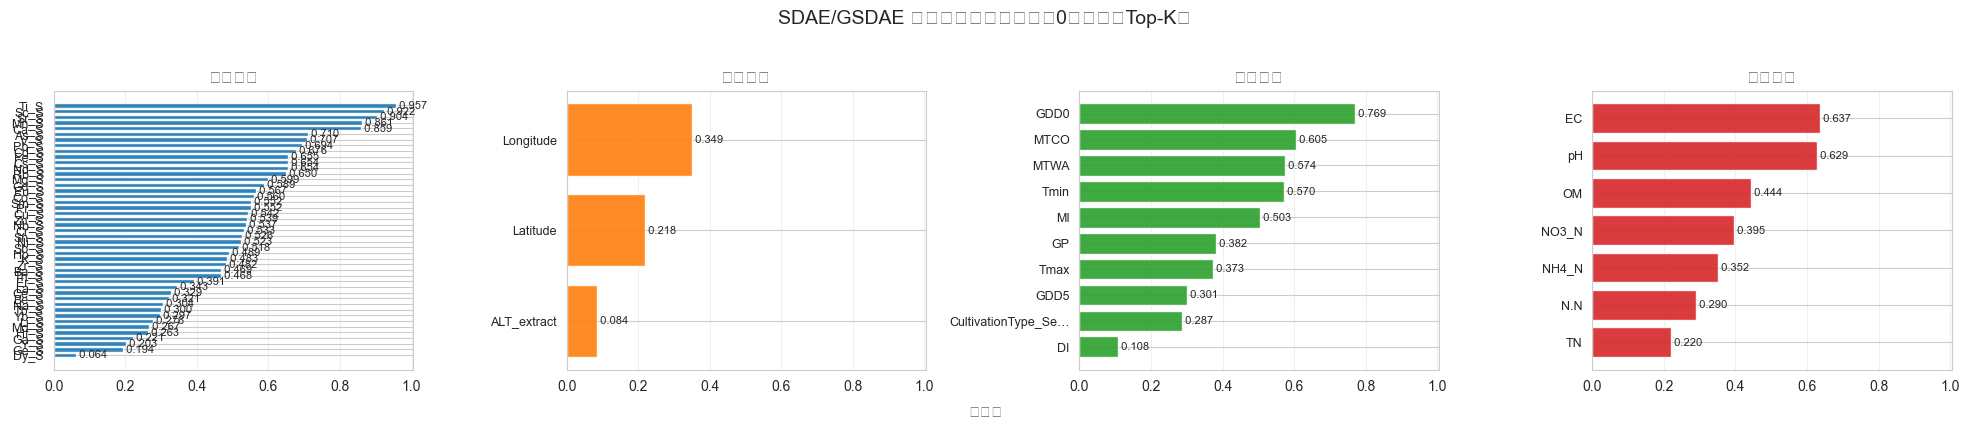

In [24]:
# 中文字体与“0权重可见”的权重面板图
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from matplotlib import font_manager as fm
from matplotlib.font_manager import FontProperties

def set_cn_font():
    """自动注册并启用中文字体"""
    candidates = [
        r"C:\Windows\Fonts\msyh.ttc",   # 微软雅黑
        r"C:\Windows\Fonts\msyh.ttf",
        r"C:\Windows\Fonts\simhei.ttf", # 黑体
        r"C:\Windows\Fonts\simsun.ttc"  # 宋体
    ]
    chosen = None
    for p in candidates:
        if os.path.exists(p):
            try:
                fm.fontManager.addfont(p)
                chosen = FontProperties(fname=p).get_name()
                break
            except Exception:
                pass
    if chosen is None:
        # 回退到常用名称
        chosen = "Microsoft YaHei"
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [chosen, 'SimHei', 'SimSun', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    print(f"已设置中文字体: {chosen}")

set_cn_font()
sns.set_style("whitegrid")

def _get_layer_kernel(layer):
    if hasattr(layer, "kernel") and layer.kernel is not None:
        w = layer.kernel.numpy()
        return np.asarray(w, dtype=float)
    raise ValueError("layer 不含 kernel 权重，请确认传入的是 GroupSelectiveLayer/ImprovedGroupSelectiveLayer 的实例。")

def compute_group_feature_weights(layer, feature_groups, feature_names):
    """返回 {组名: [(特征名, 权重), ...]}（包含0值）"""
    weights = _get_layer_kernel(layer)
    result = {}
    for g, idx in feature_groups.items():
        
        if len(idx) == 0:
            continue
        pairs = [(feature_names[i], float(max(0.0, weights[i]))) for i in idx]  # 负值截断为0，保留0
        result[g] = pairs
    return result

def plot_group_weight_panels(group_feature_weights, top_k=None, group_order=None, ncols=4, zero_min_ratio=0.02):
    """
    绘制各组Top-K特征权重面板
    - top_k=None 显示组内全部特征
    - zero_min_ratio: 0值条形显示为 (global_max * ratio) 的最小宽度
    """
    # 组显示顺序
    keys = list(group_feature_weights.keys())
    if group_order:
        ordered = [g for g in group_order if g in group_feature_weights] + [g for g in keys if g not in group_order]
    else:
        ordered = keys

    ordered_map = OrderedDict((g, group_feature_weights[g]) for g in ordered)
    ng = len(ordered_map)
    ncols = min(ncols, max(1, ng))
    nrows = int(np.ceil(ng / ncols))

    # 统一x轴上限，便于对比（按真实权重计算）
    all_vals = [w for feats in ordered_map.values() for _, w in feats] or [0.0]
    global_max = float(max(all_vals))
    if global_max <= 0:
        global_max = 1.0  # 全0时的可视上限
    xlim = global_max * 1.05
    min_bar = max(global_max * zero_min_ratio, 1e-6)  # 0值条的最小显示宽度

    palette = sns.color_palette("tab10", n_colors=max(10, ng))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols+0.6, 3.2*nrows+1), squeeze=False, sharex=True)
    ax_list = axes.flatten()

    # 先关掉所有坐标轴，避免空格子显示框线
    for ax in ax_list:
        ax.axis("off")

    for i, (g, feats) in enumerate(ordered_map.items()):
        ax = ax_list[i]
        ax.axis("on")
        feats_sorted = sorted(feats, key=lambda x: x[1], reverse=True)
        if top_k is not None:
            feats_sorted = feats_sorted[:top_k]

        names = [n if len(n) <= 18 else n[:18] + "…" for n, _ in feats_sorted][::-1]
        vals_true = [v for _, v in feats_sorted][::-1]
        # 0值条形使用最小宽度渲染，但保留真实数值标注
        vals_plot = [v if v > 0 else min_bar for v in vals_true]

        ax.barh(names, vals_plot, color=palette[i % len(palette)], alpha=0.9)
        ax.set_title(g, fontsize=12, pad=6)
        ax.set_xlim(0, xlim)
        ax.grid(True, axis='x', alpha=0.3)
        ax.tick_params(axis='y', labelsize=9)

        # 数值标注（使用真实值；位置用绘制宽度以保证可见）
        for y, (vp, vt) in enumerate(zip(vals_plot, vals_true)):
            ax.text(vp, y, f" {vt:.3f}", va='center', ha='left', fontsize=8)

    fig.suptitle("SDAE/GSDAE 各特征组权重分布（含0值；每组Top-K）", fontsize=14)
    fig.text(0.5, 0.01, "权重值", ha='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
# 从训练好的GSDAE模型中按名称获取组选择层的实例
try:
    layer_inst = GSDAE.get_layer('group_selective_layer')
    if layer_inst is None:
        raise RuntimeError("在GSDAE模型中未找到名为 'group_selective_layer' 的层。")
except NameError:
    raise NameError("模型 'GSDAE' 未定义。请确保前面的模型训练单元格已成功运行。")


group_feature_weights = compute_group_feature_weights(layer_inst, feature_groups, feature_names)
# 推荐顺序；top_k=None 显示组内全部特征（包含0）
preferred_order = ["土壤元素", "作物元素", "土壤养分", "地理信息", "气候环境",
                   "省份", "城市", "地貌", "土壤类型", "栽培类型", "气候类型"]

plot_group_weight_panels(group_feature_weights, top_k=None, group_order=preferred_order, ncols=4, zero_min_ratio=0.02)

结果将保存在 'results' 文件夹中。

GSDAE 模型分析报告 (2025-11-06 16:36:52)

### 1. 最佳超参数 ###
 - learning_rate: 0.005
 - group_lasso_rate: 0.0001492073979042345
 - l1_rate: 2.7255731067274567e-05
 - prediction_weight: 0.1

### 2. 模型评估指标 ###
 - 目标预测 - 测试 R²: 0.3868
 - 目标预测 - 测试 MAE (原单位): 2.246380
 - 目标预测 - 训练 R²: 0.8311
 - 目标预测 - 训练 MAE (原单位): 1.312036
--------------------
 - 重构任务 - 测试 MSE: 0.460699
 - 预测任务 - 测试 MSE: 0.490682

### 3. 特征组重要性排名 (RMS) ###
 1. 土壤元素        : 0.5554
 2. 气候环境        : 0.4832
 3. 理化性质        : 0.4490
 4. 地理信息        : 0.2427

### 4. 各组内关键特征 (Top 3) ###

--- 土壤元素 ---
  1. Ti_S: 0.9570
  2. Sc_S: 0.9216
  3. Sr_S: 0.9039

--- 理化性质 ---
  1. EC: 0.6373
  2. pH: 0.6292
  3. OM: 0.4436

--- 地理信息 ---
  1. Longitude: 0.3494
  2. Latitude: 0.2180
  3. ALT_extract: 0.0841

--- 气候环境 ---
  1. GDD0: 0.7694
  2. MTCO: 0.6051
  3. MTWA: 0.5741

✅ 文本摘要已保存至: results\model_summary.txt


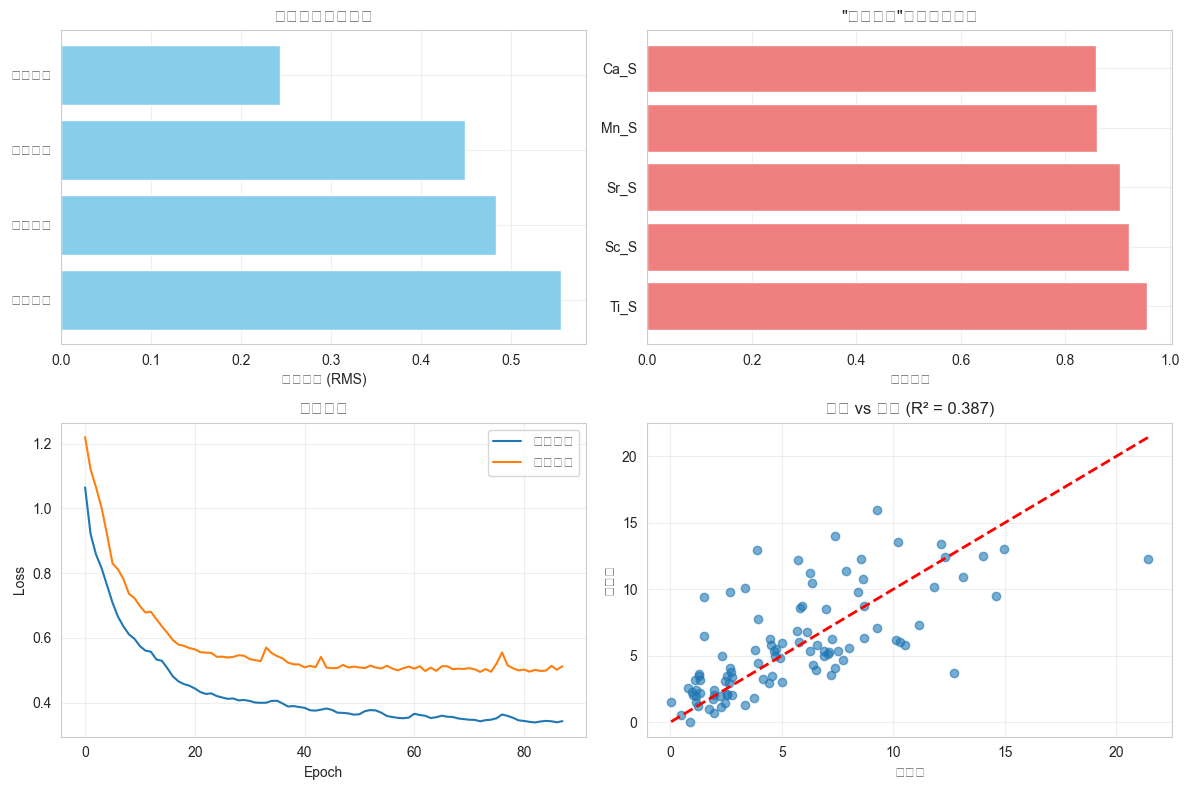

✅ 综合评估图已保存至: results\evaluation_summary.png


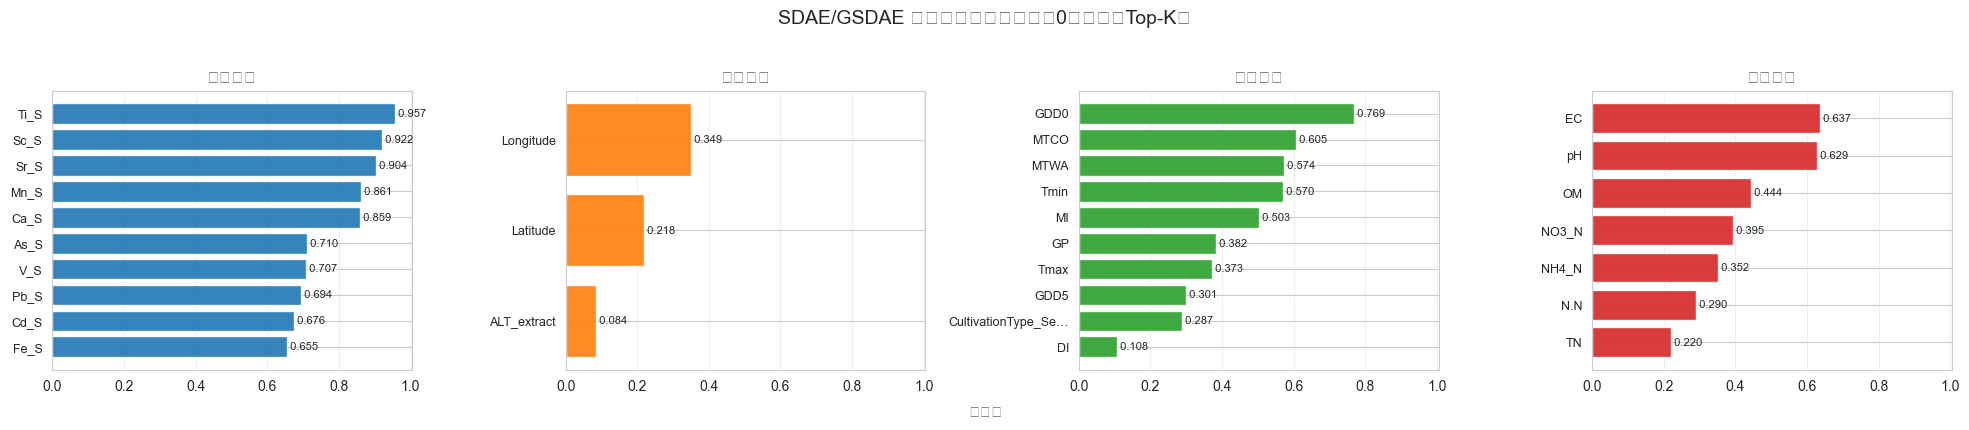

✅ Top-10 特征权重图已保存至: results\feature_weights_top10.png


<Figure size 640x480 with 0 Axes>

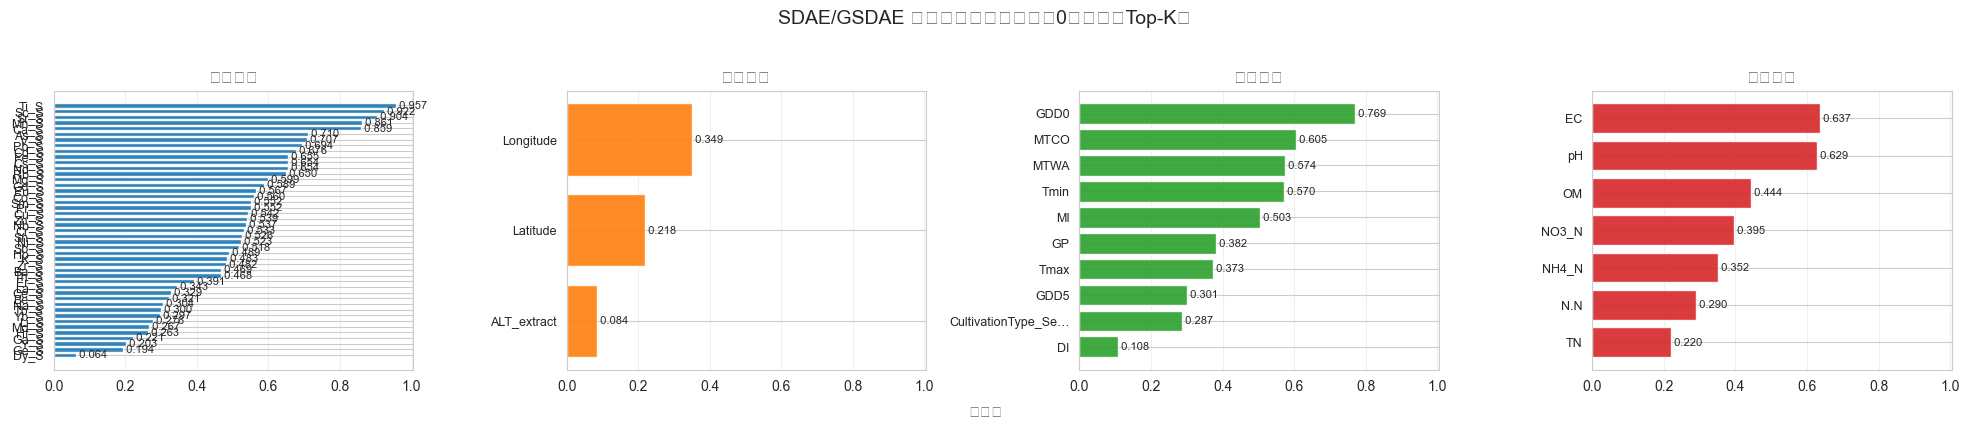

✅ 全特征权重图已保存至: results\feature_weights_all.png


<Figure size 640x480 with 0 Axes>

In [25]:


# --- 1. 创建结果输出目录 ---
output_dir = 'results'
os.makedirs(output_dir, exist_ok=True)
print(f"结果将保存在 '{output_dir}' 文件夹中。\n")

# --- 2. 准备文本摘要内容 ---
summary_content = []
summary_content.append("=" * 50)
summary_content.append(f"GSDAE 模型分析报告 ({datetime.now().strftime('%Y-%m-%d %H:%M:%S')})")
summary_content.append("=" * 50)

# a. 最佳超参数
if 'best_hps' in locals():
    summary_content.append("\n### 1. 最佳超参数 ###")
    summary_content.append(f" - learning_rate: {best_hps.get('learning_rate')}")
    summary_content.append(f" - group_lasso_rate: {best_hps.get('group_lasso_rate')}")
    summary_content.append(f" - l1_rate: {best_hps.get('l1_rate')}")
    summary_content.append(f" - prediction_weight: {best_hps.get('prediction_weight')}")

# b. 模型评估指标
summary_content.append("\n### 2. 模型评估指标 ###")
summary_content.append(f" - 目标预测 - 测试 R²: {test_r2:.4f}")
summary_content.append(f" - 目标预测 - 测试 MAE (原单位): {test_mae_pred_orig:.6f}")
summary_content.append(f" - 目标预测 - 训练 R²: {train_r2:.4f}")
summary_content.append(f" - 目标预测 - 训练 MAE (原单位): {train_mae_pred_orig:.6f}")
summary_content.append("-" * 20)
summary_content.append(f" - 重构任务 - 测试 MSE: {test_mse_recon:.6f}")
summary_content.append(f" - 预测任务 - 测试 MSE: {test_mse_pred:.6f}")

# c. 特征重要性
if 'sorted_groups' in locals() and 'feature_importance' in locals():
    summary_content.append("\n### 3. 特征组重要性排名 (RMS) ###")
    for i, (group_name, importance) in enumerate(sorted_groups):
        summary_content.append(f"{i+1:2d}. {group_name:12s}: {importance:.4f}")

    summary_content.append("\n### 4. 各组内关键特征 (Top 3) ###")
    for group_name, features in feature_importance.items():
        summary_content.append(f"\n--- {group_name} ---")
        for i, (feat_name, weight) in enumerate(features[:3]):
            summary_content.append(f"  {i+1}. {feat_name}: {weight:.4f}")

# --- 3. 打印并保存文本摘要 ---
summary_text = "\n".join(summary_content)
print(summary_text)

summary_filepath = os.path.join(output_dir, 'model_summary.txt')
with open(summary_filepath, 'w', encoding='utf-8') as f:
    f.write(summary_text)
print(f"\n✅ 文本摘要已保存至: {summary_filepath}")


# --- 4. 重新生成并保存所有图表 ---

# a. 保存综合评估图
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# 组重要性
top_n_groups = min(8, len(sorted_groups))
groups = [item[0] for item in sorted_groups[:top_n_groups]]
importance = [item[1] for item in sorted_groups[:top_n_groups]]
axes[0, 0].barh(groups, importance, color='skyblue')
axes[0, 0].set_xlabel('组重要性 (RMS)')
axes[0, 0].set_title('特征组重要性排名')
axes[0, 0].grid(True, alpha=0.3)
# 最重要组的关键特征
if sorted_groups:
    top_group = sorted_groups[0][0]
    top_features = feature_importance[top_group][:5]
    feature_names_short = [item[0][:15] + '...' if len(item[0]) > 15 else item[0] for item in top_features]
    feature_weights = [item[1] for item in top_features]
    axes[0, 1].barh(feature_names_short, feature_weights, color='lightcoral')
    axes[0, 1].set_xlabel('特征权重')
    axes[0, 1].set_title(f'"{top_group}"组内关键特征')
    axes[0, 1].grid(True, alpha=0.3)
# 训练损失
axes[1, 0].plot(history_gsdae.history['loss'], label='训练损失')
axes[1, 0].plot(history_gsdae.history['val_loss'], label='验证损失')
axes[1, 0].set_title('训练损失')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
# 预测准确性
axes[1, 1].scatter(y_test_orig, test_target_pred_orig, alpha=0.6)
axes[1, 1].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('实际值')
axes[1, 1].set_ylabel('预测值')
axes[1, 1].set_title(f'预测 vs 实际 (R² = {test_r2:.3f})')
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
eval_fig_path = os.path.join(output_dir, 'evaluation_summary.png')
plt.savefig(eval_fig_path, dpi=300)
plt.show()
print(f"✅ 综合评估图已保存至: {eval_fig_path}")

# b. 保存 Top-10 特征权重图
plot_group_weight_panels(group_feature_weights, top_k=10, group_order=preferred_order, ncols=4)
top10_fig_path = os.path.join(output_dir, 'feature_weights_top10.png')
plt.savefig(top10_fig_path, dpi=300)
print(f"✅ Top-10 特征权重图已保存至: {top10_fig_path}")


# c. 保存全特征权重图
plot_group_weight_panels(group_feature_weights, top_k=None, group_order=preferred_order, ncols=4, zero_min_ratio=0.02)
all_weights_fig_path = os.path.join(output_dir, 'feature_weights_all.png')
plt.savefig(all_weights_fig_path, dpi=300)
print(f"✅ 全特征权重图已保存至: {all_weights_fig_path}")